<a href="https://colab.research.google.com/github/isSiYua/aarBasicCode/blob/main/Lecture_3/image_classification_efficientnet_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification via fine-tuning with EfficientNet optimisation


**Name**: Zhang Zhenwei

**Student ID**: 202510979

**Lecture Number**: lecture 3

**Demo File**: image_classification_efficient_fine_tuning.ipynb

**Colab Link**: [Colab](https://colab.research.google.com/github/isSiYua/aarBasicCode/blob/main/Lecture_3/image_classification_efficientnet_fine_tuning.ipynb)

# Introduction

For this assignment, I have chosen to improve the Image Classification via fine-tuning with EfficientNet demo.

# Goal of the optimisation
Improve the model's generalization capabilities and representational capacity for fine-tuning.

The baseline model demonstrated severe overfitting when trained from scratch and showed room for improvement in the transfer learning stage. Therefore, the primary goal of this optimization is to enhance the model's feature extraction capacity, mitigate overfitting, and improve overall validation accuracy by modifying the data augmentation pipeline, network architecture, and regularization techniques.

# Method

1. **Image Augmentation**: Added `RandomZoom` and increased the factor of `RandomRotation` and `RandomContrast` to expose the model to more complex visual perturbations.

2. **Network Architecture**: Injected an additional hidden `Dense` layer (512 units) with `ReLU` activation and an extra `BatchNormalization` layer before the final classifier to allow learning more complex non-linear combinations of the extracted features.

3. **Dropout**: Increased the top dropout rate from `0.2` to `0.4` to counteract potential overfitting caused by the newly added Dense layer.

4. **Optimization Function**: Switched the optimizer from standard `Adam` to `Nadam` (Nesterov-accelerated Adaptive Moment Estimation) and adjusted learning rates to achieve smoother gradient updates during both the initial transfer learning phase and the fine-tuning phase.

5. **Checkpointing Mechanism**: Added a `ModelCheckpoint` callback to save model weights to Google Drive, preventing data loss from unexpected Colab session disconnections.

# Results
The table below summarizes the final epoch performance of both the Original Code and the Improved Code across the three training stages:

| Training Stage   | Model Version             | Train Accuracy | Train Loss | Val Accuracy | Val Loss   |
| :--------------- | :------------------------ | :------------- | :--------- | :----------- | :--------- |
| **1. Scratch**   | Original (100 Epochs)     | 0.9480         | 0.1623     | 0.2536       | 5.9686     |
|                  | **Improved** (100 Epochs) | 0.9414         | 0.1845     | 0.2430       | 6.0740     |
| **2. Transfer**  | Original (80 Epochs)      | 0.7276         | 1.1076     | 0.7750       | 1.0256     |
|                  | **Improved** (80 Epochs)  | **0.8332**     | **0.5455** | **0.8050**   | **0.7901** |
| **3. Fine-tune** | Original (50 Epochs)      | 0.9585         | 0.1274     | 0.7979       | 0.9746     |
|                  | **Improved** (50 Epochs)  | 0.9541         | 0.1446     | 0.7921       | **0.9557** |


# Discussion
Based on the experimental results, several key observations can be made:
* **Training from Scratch:** Both the original and improved models suffer from extreme overfitting (Train Acc > 94%, Val Acc ~24%). This strongly indicates that training a deep, complex architecture like EfficientNetB0 from scratch on a relatively small dataset is highly ineffective, regardless of architectural tweaks.

* **Transfer Learning:** The improvements are most prominent here. The improved model significantly boosted both training accuracy (from 72.76% to 83.32%) and validation accuracy (from 77.50% to 80.50%), while drastically reducing the validation loss (from 1.0256 to 0.7901). The addition of the 512-unit Dense layer successfully increased the model's capacity to interpret the frozen features.

* **Fine-tuning:** I expected a big improvement here, just like in transfer learning, but it did not happen. The accuracy is almost the same as the original model. This small difference might just be because of random numbers. However, the validation loss is a little bit lower (0.9557 vs 0.9746). I think the new 512-unit layer already learned enough in the transfer stage, so unfreezing the base layers didn't help much. Also, the 0.4 Dropout stopped the model from just memorizing the data.

# Conclusion
This experiment shows that Transfer Learning is much better than training from scratch. Adding a 512-unit Dense layer, changing Dropout to 0.4, and using RandomZoom successfully made the model perform better and more stable in the transfer learning stage.


# Original Code

In [1]:
pre_trained_flag = False # Set to False if you want to train the models

In [2]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy


### Loading data

In [5]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.0R2STU_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.0R2STU_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Resize the image to the input size needed for EfficientNet.

In [6]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

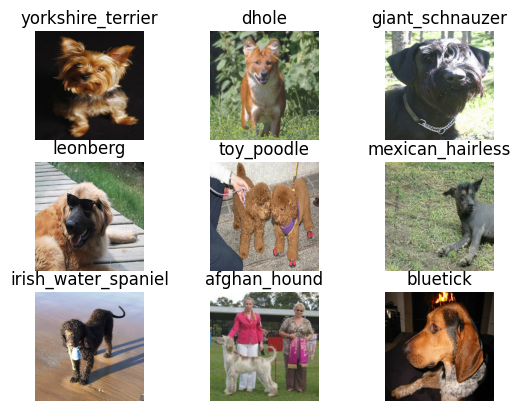

In [7]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

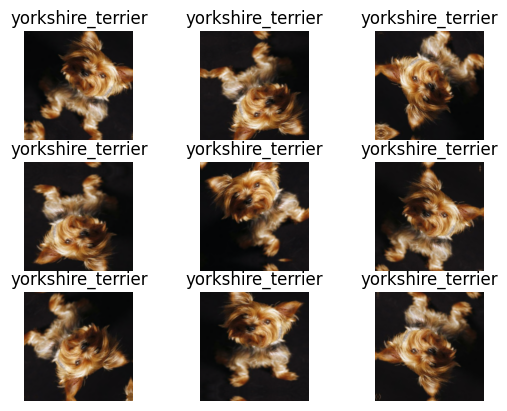

In [9]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs


In [10]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


## Training a model from scratch

In [11]:
# Due to the limited training resource , I need to save training checkpoint to the google drive
from google.colab import drive
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# load Google Drive
drive.mount('/content/drive')

dir_scratch = '/content/drive/MyDrive/Colab_Checkpoints/Model1_Scratch/'
dir_transfer = '/content/drive/MyDrive/Colab_Checkpoints/Model2_Transfer/'
dir_finetune = '/content/drive/MyDrive/Colab_Checkpoints/Model3_Finetune/'

os.makedirs(dir_scratch, exist_ok=True)
os.makedirs(dir_transfer, exist_ok=True)
os.makedirs(dir_finetune, exist_ok=True)

print("云盘挂载成功，三个训练阶段的目录已就绪！")

Mounted at /content/drive
云盘挂载成功，三个训练阶段的目录已就绪！


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
from tensorflow.keras.applications import EfficientNetB0

if not pre_trained_flag:

    import json

    with strategy.scope():
        inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = img_augmentation(inputs)
        outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

    model.summary()

    save_step_frequency = 5 * len(ds_train)
    cp_callback_1 = ModelCheckpoint(
        filepath=dir_scratch + "cp-{epoch:04d}.weights.h5",
        save_weights_only=True, verbose=5, save_freq=save_step_frequency
    )

    epochs = 100
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2,callbacks=[cp_callback_1])

    json.dump(hist.history, open('./hist_m1.json', 'w'))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_augmentation (Sequential)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 120)            │     4,203,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/100
187/187 - 36s - 193ms/step - accuracy: 0.0136 - loss: 4.9746 - val_accuracy: 0.0139 - val_loss: 4.9975
Epoch 2/100
187/187 - 23s - 123ms/step - accuracy: 0.0221 - loss: 4.6314 - val_accuracy: 0.0167 - val_loss: 5.0090
Epoch 3/100
187/187 - 23s - 123ms/step - accuracy: 0.0342 - loss: 4.4405 - val_accuracy: 0.0364 - val_loss: 4.4839
Epoch 4/100
187/187 - 23s - 124ms/step - accuracy: 0.0427 - loss: 4.3070 - val_accuracy: 0.0381 - val_loss: 4.4069
Epoch 5/100

Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model1_Scratch/cp-0005.weights.h5
187/187 - 27s - 146ms/step - accuracy: 0.0529 - loss: 4.2059 - val_accuracy: 0.0420 - val_loss: 4.7259
Epoch 6/100
187/187 - 23s - 124ms/step - accuracy: 0.0632 - loss: 4.1205 - val_accuracy: 0.0532 - val_loss: 4.2773
Epoch 7/100
187/187 - 23s - 124ms/step - accuracy: 0.0719 - loss: 4.0274 - val_accuracy: 0.0723 - val_loss: 4.0139
Epoch 8/100
187/187 - 23s - 124ms/step - accuracy: 0.0826 - loss: 3.9490 - val_accuracy: 0.071

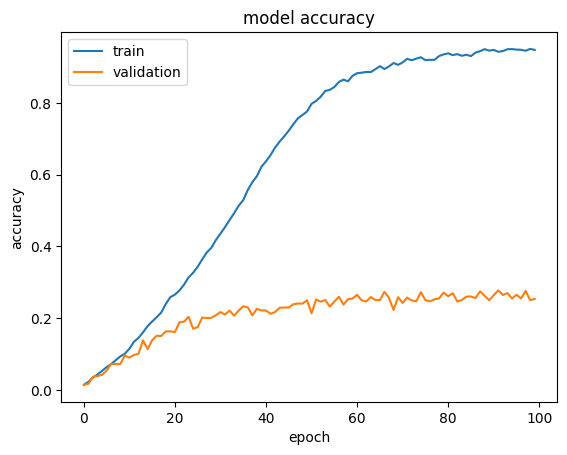

In [14]:
import matplotlib.pyplot as plt

history_dict = json.load(open('./hist_m1.json', 'r'))


def plot_hist(hist):
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_dict)

## Transfer learning from pre-trained weights


In [15]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/80
187/187 - 12s - 64ms/step - accuracy: 0.4205 - loss: 3.2466 - val_accuracy: 0.7422 - val_loss: 0.8523
Epoch 2/80
187/187 - 7s - 40ms/step - accuracy: 0.5834 - loss: 1.6508 - val_accuracy: 0.7698 - val_loss: 0.7380
Epoch 3/80
187/187 - 7s - 40ms/step - accuracy: 0.6302 - loss: 1.3364 - val_accuracy: 0.7882 - val_loss: 0.6897
Epoch 4/80
187/187 - 7s - 40ms/step - accuracy: 0.6547 - loss: 1.2176 - val_accuracy: 0.7819 - val_loss: 0.7224
Epoch 5/80

Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model2_Transfer/cp-0005.weights.h5
187/187 - 10s - 51ms/step - accuracy: 0.6634 - loss: 1.1714 - val_accuracy: 0.7837 - val_loss: 0.7393
Epoch 6/80
187/187 - 7s - 40ms/step - accuracy: 0.6700 - loss: 1.1401 - val_accuracy: 0.8031 - val_loss: 0.6666
Epoch 7/80
187/187 - 7s - 40ms/step - accuracy: 0.6722 - loss: 1.1416 - val_accuracy: 0.7920 - val_loss: 0.7150
Epoch 8/80
187/187 - 7s - 40ms/step - accuracy: 0.6761 - loss

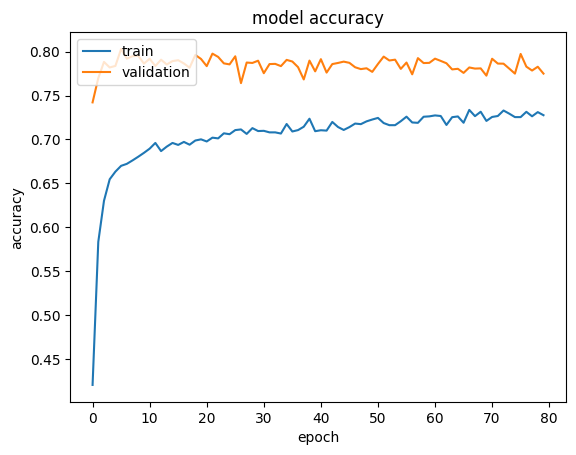

In [16]:
if not pre_trained_flag:
    with strategy.scope():
        model = build_model(num_classes=NUM_CLASSES)

    epochs = 80
    save_step_frequency = 5 * len(ds_train)
    cp_callback_2 = ModelCheckpoint(
        filepath=dir_transfer + "cp-{epoch:04d}.weights.h5",
        save_weights_only=True, verbose=5, save_freq=save_step_frequency
    )
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2, callbacks=[cp_callback_2])


    plot_hist(hist.history)

Epoch 1/50
187/187 - 12s - 65ms/step - accuracy: 0.7791 - loss: 0.8428 - val_accuracy: 0.8118 - val_loss: 0.8139
Epoch 2/50
187/187 - 8s - 41ms/step - accuracy: 0.8056 - loss: 0.6863 - val_accuracy: 0.8120 - val_loss: 0.8246
Epoch 3/50
187/187 - 8s - 41ms/step - accuracy: 0.8100 - loss: 0.6441 - val_accuracy: 0.8128 - val_loss: 0.8328
Epoch 4/50
187/187 - 8s - 41ms/step - accuracy: 0.8243 - loss: 0.5973 - val_accuracy: 0.8115 - val_loss: 0.8489
Epoch 5/50

Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model3_Finetune/cp-0005.weights.h5
187/187 - 10s - 54ms/step - accuracy: 0.8371 - loss: 0.5391 - val_accuracy: 0.8095 - val_loss: 0.8514
Epoch 6/50
187/187 - 8s - 41ms/step - accuracy: 0.8430 - loss: 0.5067 - val_accuracy: 0.8117 - val_loss: 0.8483
Epoch 7/50
187/187 - 8s - 42ms/step - accuracy: 0.8603 - loss: 0.4477 - val_accuracy: 0.8089 - val_loss: 0.8574
Epoch 8/50
187/187 - 8s - 42ms/step - accuracy: 0.8654 - loss: 0.4331 - val_accuracy: 0.8117 - val_loss: 0.8315


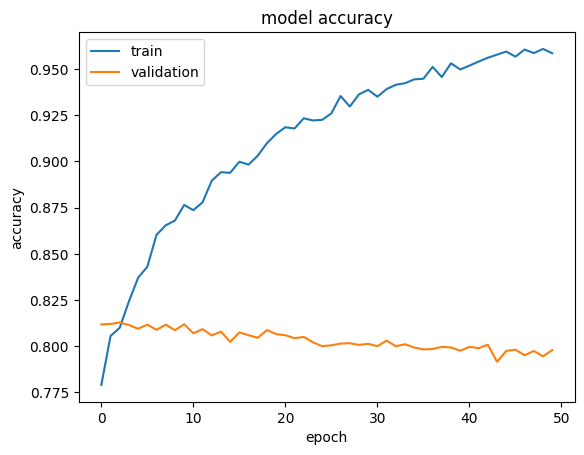

In [17]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

if not pre_trained_flag:
    with strategy.scope():
      unfreeze_model(model)

    epochs = 50

    save_step_frequency = 5 * len(ds_train)
    cp_callback_3 = ModelCheckpoint(
        filepath=dir_finetune + "cp-{epoch:04d}.weights.h5",
        save_weights_only=True, verbose=5, save_freq=save_step_frequency
    )
    hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2, callbacks=[cp_callback_3])
    plot_hist(hist.history)

# New Code for optimization

First, modified the original image augmentation by adding a RandomZoom layer.

In [23]:
drive.mount('/content/drive')
dir_scratch = '/content/drive/MyDrive/Colab_Checkpoints/Model1UP_Scratch/'
dir_transfer = '/content/drive/MyDrive/Colab_Checkpoints/Model2UP_Transfer/'
dir_finetune = '/content/drive/MyDrive/Colab_Checkpoints/Model3UP_Finetune/'
os.makedirs(dir_transfer, exist_ok=True)
os.makedirs(dir_transfer, exist_ok=True)
os.makedirs(dir_finetune, exist_ok=True)

IMG_SIZE = 224
batch_size = 64

img_augmentation_update = Sequential(
  [
    layers.RandomRotation(factor=0.20),
      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
      layers.RandomFlip(),
      layers.RandomContrast(factor=0.20),
      layers.RandomZoom(height_factor=0.2, width_factor=0.2),
  ],
        name="img_augmentation",
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


training the model with new augmentation

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_augmentation (Sequential)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 120)            │     4,203,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - accuracy: 0.0066 - loss: 5.0947 - val_accuracy: 0.0080 - val_loss: 4.8508
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.0201 - loss: 4.6665 - val_accuracy: 0.0154 - val_loss: 4.8844
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.0324 - loss: 4.4612 - val_accuracy: 0.0372 - val_loss: 4.4313
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.0439 - loss: 4.3312 - val_accuracy: 0.0310 - val_loss: 4.5726
Epoch 5/100
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0472 - loss: 4.2178
Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model1UP_Scratch/cp-0005.weights.h5
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.0472 - loss: 4.2176 - val_accuracy: 0.0477 - val_loss: 4.3149
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.0621 - loss: 4.1142 - val_accuracy: 0.0594 - val_loss: 4.1493
Epoch 7/100
187/187 ━━━━━━━━━

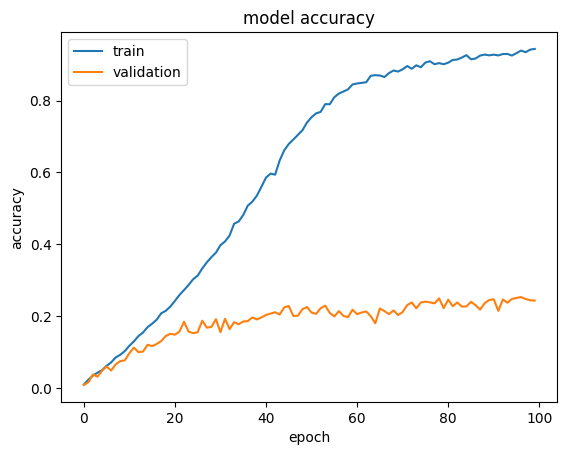

In [24]:
with strategy.scope():
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation_update(inputs)
  outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
  optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
  )

model.summary()

save_step_frequency = 5 * len(ds_train)
cp_callback_1 = ModelCheckpoint(
  filepath=dir_scratch + "cp-{epoch:04d}.weights.h5",
  save_weights_only=True, verbose=1, save_freq=save_step_frequency
)

epochs = 100
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1,callbacks=[cp_callback_1])
plot_hist(hist.history)

Adding some layers to enhance the model performance

Adding an additional 512-unit Dense layer along with Batch Normalization

Changing the dropout layer

Epoch 1/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.2880 - loss: 3.2585 - val_accuracy: 0.7313 - val_loss: 0.8726
Epoch 2/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4761 - loss: 2.0087 - val_accuracy: 0.7544 - val_loss: 0.7905
Epoch 3/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5182 - loss: 1.7510 - val_accuracy: 0.7746 - val_loss: 0.7383
Epoch 4/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5442 - loss: 1.6166 - val_accuracy: 0.7888 - val_loss: 0.6747
Epoch 5/80
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5720 - loss: 1.4909
Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model2UP_Transfer/cp-0005.weights.h5
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5720 - loss: 1.4909 - val_accuracy: 0.7895 - val_loss: 0.6751
Epoch 6/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5935 - loss: 1.4244 - val_accuracy: 0.7942 - val_loss: 0.6508
Epoch 7/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 41m

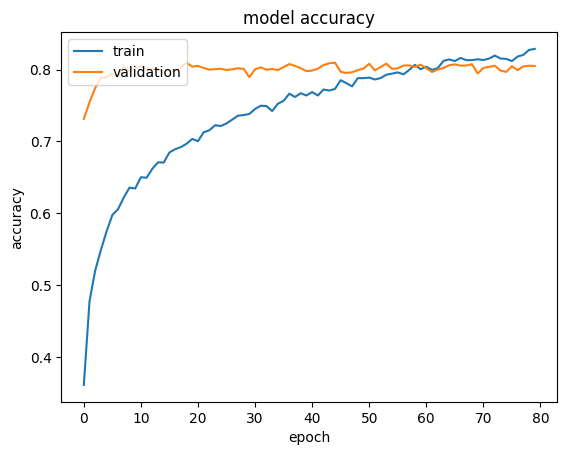

In [25]:
def build_improved_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation_update(inputs)

    base_model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(512, activation="relu", name="hidden_dense")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.4, name="top_dropout")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet_Improved")

    optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


with strategy.scope():
    improved_model = build_improved_model(NUM_CLASSES)

epochs_transfer = 80

save_step_frequency = 5 * len(ds_train)

cp_callback_transfer = tf.keras.callbacks.ModelCheckpoint(
    filepath=dir_transfer + "cp-{epoch:04d}.weights.h5",
    save_weights_only=True,
    verbose=1,
    save_freq=save_step_frequency
)

hist = improved_model.fit(
    ds_train, epochs=epochs_transfer, validation_data=ds_test, verbose=1, callbacks=[cp_callback_transfer]
)
plot_hist(hist.history)

Initially, I changed the optimizer from Adam to Nadam to test if it could improve the results.

However, since Nadam yielded worse performance, I switched back to Adam to restore the model's accuracy.

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9247 - loss: 0.2271 - val_accuracy: 0.8069 - val_loss: 0.8348
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9235 - loss: 0.2258 - val_accuracy: 0.8042 - val_loss: 0.8520
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9211 - loss: 0.2300 - val_accuracy: 0.8022 - val_loss: 0.8571
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9244 - loss: 0.2374 - val_accuracy: 0.8021 - val_loss: 0.8457
Epoch 5/50
184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9244 - loss: 0.2317
Epoch 5: saving model to /content/drive/MyDrive/Colab_Checkpoints/Model3UP_Finetune/cp-0005.weights.h5
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9244 - loss: 0.2318 - val_accuracy: 0.7993 - val_loss: 0.8581
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9241 - loss: 0.2279 - val_accuracy: 0.8019 - val_loss: 0.8618
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 43

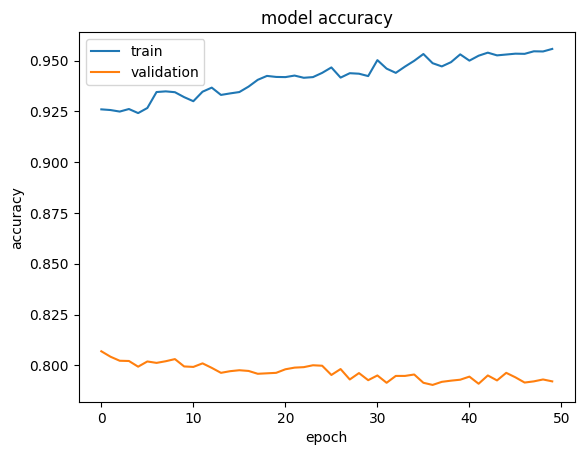

In [28]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

with strategy.scope():
    unfreeze_model(improved_model)

epochs_finetune = 50

cp_callback_finetune = tf.keras.callbacks.ModelCheckpoint(
    filepath=dir_finetune + "cp-{epoch:04d}.weights.h5",
    save_weights_only=True,
    verbose=1,
    save_freq=save_step_frequency
)

hist = improved_model.fit(
    ds_train, epochs=epochs_finetune, validation_data=ds_test, verbose=1, callbacks=[cp_callback_finetune]
)

plot_hist(hist.history)